# Data Science with Python and Dask

In [5]:
from datetime import datetime

import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import dask.delayed as delayed
import pyarrow

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Chapter 2 Introducing Dask

In [2]:
df = dd.read_csv('nyc-parking-tickets/*2017.csv')

In [3]:
df

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
npartitions=33,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,object,object,object,object,int64,object,object,object,int64,int64,int64,int64,float64,int64,int64,int64,object,object,object,object,object,object,object,object,object,int64,int64,object,object,object,object,object,object,float64,int64,object,int64,object,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Counting the missing values

In [4]:
missing_values = df.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
Date First Observed    int64
Violation Time           ...
dtype: int64
Dask Name: dataframe-sum-agg, 100 tasks

In [5]:
missing_count = (missing_values/df.index.size)*100
missing_count

Dask Series Structure:
npartitions=1
Date First Observed    float64
Violation Time             ...
dtype: float64
Dask Name: mul, 169 tasks

In [7]:
with ProgressBar():
    missing_count_pct = missing_count.compute()
missing_count_pct

[##################################      ] | 86% Completed | 51.5s

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py:119: DtypeWarning: Columns (18,38) have mixed types.Specify dtype option on import or set low_memory=False.
  result = (True, func(*args, **kwds))


[########################################] | 100% Completed | 54.1s


Summons Number                         0.000000
Plate ID                               0.006739
Registration State                     0.000000
Plate Type                             0.000000
Issue Date                             0.000000
Violation Code                         0.000000
Vehicle Body Type                      0.395361
Vehicle Make                           0.676199
Issuing Agency                         0.000000
Street Code1                           0.000000
Street Code2                           0.000000
Street Code3                           0.000000
Vehicle Expiration Date                0.000000
Violation Location                    19.183510
Violation Precinct                     0.000000
Issuer Precinct                        0.000000
Issuer Code                            0.000000
Issuer Command                        19.093212
Issuer Squad                          19.101506
Violation Time                         0.000583
Time First Observed                   92

## 2.5 Filtering sparse columns

In [30]:
columns_to_drop = missing_count_pct[missing_count_pct>60].index
with ProgressBar():
    df_dropped = df.drop(columns_to_drop, axis=1).persist()

[################################        ] | 81% Completed | 44.1s

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/dask/core.py:121: DtypeWarning: Columns (18,38) have mixed types.Specify dtype option on import or set low_memory=False.
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 46.5s


### get the shape of df_dropped

In [37]:
df_dropped_shape = df_dropped.shape
df_shape = [0, df_dropped_shape[1]]
with ProgressBar():
    df_shape[0] = df_dropped_shape[0].compute()
df_shape

[########################################] | 100% Completed |  0.1s


[10803028, 35]

## 2.6 Creating some functions

In [3]:
def inc(i): return i+1
def add(x, y): return x + y

In [27]:
x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

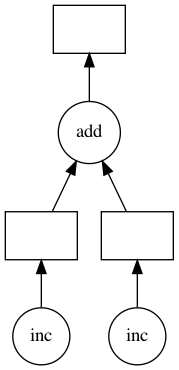

In [28]:
z.visualize(format='png')

In [21]:
z.compute()

5

In [25]:
z

Delayed('add-e291c50c-42ff-4c8a-b146-579d96288538')

In [43]:
#missing_count.visualize()

# Chapter 5 Cleaning and Transforming Dataframes

In [192]:
dtypes = {
 'Date First Observed': np.str,
 'Days Parking In Effect    ': np.str,
 'Double Parking Violation': np.str,
 'Feet From Curb': np.float32,
 'From Hours In Effect': np.str,
 'House Number': np.str,
 'Hydrant Violation': np.str,
 'Intersecting Street': np.str,
 'Issue Date': np.str,
 'Issuer Code': np.float32,
 'Issuer Command': np.str,
 'Issuer Precinct': np.float32,
 'Issuer Squad': np.str,
 'Issuing Agency': np.str,
 'Law Section': np.float32,
 'Meter Number': np.str,
 'No Standing or Stopping Violation': np.str,
 'Plate ID': np.str,
 'Plate Type': np.str,
 'Registration State': np.str,
 'Street Code1': np.uint32,
 'Street Code2': np.uint32,
 'Street Code3': np.uint32,
 'Street Name': np.str,
 'Sub Division': np.str,
 'Summons Number': np.uint32,
 'Time First Observed': np.str,
 'To Hours In Effect': np.str,
 'Unregistered Vehicle?': np.str,
 'Vehicle Body Type': np.str,
 'Vehicle Color': np.str,
 'Vehicle Expiration Date': np.str,
 'Vehicle Make': np.str,
 'Vehicle Year': np.float32,
 'Violation Code': np.uint16,
 'Violation County': np.str,
 'Violation Description': np.str,
 'Violation In Front Of Or Opposite': np.str,
 'Violation Legal Code': np.str,
 'Violation Location': np.str,
 'Violation Post Code': np.str,
 'Violation Precinct': np.float32,
 'Violation Time': np.str
}


In [193]:
nyc_data_raw = dd.read_csv('nyc-parking-tickets/*.csv', dtype=dtypes, usecols=dtypes.keys())

In [194]:
with ProgressBar():
           print(nyc_data_raw[['Plate ID', 'Registration State']].head())

[########################################] | 100% Completed |  1.8s
  Plate ID Registration State
0  GBB9093                 NY
1  62416MB                 NY
2  78755JZ                 NY
3  63009MA                 NY
4  91648MC                 NY


## 5.1 Working with indexes and axes

In [31]:
with ProgressBar():
    display(nyc_data_raw['Plate ID'].head())

[########################################] | 100% Completed |  1.7s


0    GBB9093
1    62416MB
2    78755JZ
3    63009MA
4    91648MC
Name: Plate ID, dtype: object

In [34]:
with ProgressBar():
    print(nyc_data_raw['Plate ID'].head())

[########################################] | 100% Completed |  1.7s
0    GBB9093
1    62416MB
2    78755JZ
3    63009MA
4    91648MC
Name: Plate ID, dtype: object


### listing 5.2 Selecting multiple columns from a dataframe

In [76]:
nyc_data_2cols = nyc_data_raw[['Plate ID', 'Registration State']]
with ProgressBar():
    print(nyc_data_2cols.head())

[########################################] | 100% Completed |  1.6s
  Plate ID Registration State
0  GBB9093                 NY
1  62416MB                 NY
2  78755JZ                 NY
3  63009MA                 NY
4  91648MC                 NY


In [71]:
with ProgressBar():
    display(nyc_data_raw.drop('Violation Code', axis=1).head())

[########################################] | 100% Completed |  1.8s


,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,...,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
0,1283294138,GBB9093,NY,PAS,08/04/2013,SUBN,AUDI,P,37250,13610,...,GY,0,2013.0,-,0.0,NaN,NaN,NaN,NaN,NaN
1,1283294151,62416MB,NY,COM,08/04/2013,VAN,FORD,P,37290,40404,...,WH,0,2012.0,-,0.0,NaN,NaN,NaN,NaN,NaN
2,1283294163,78755JZ,NY,COM,08/05/2013,P-U,CHEVR,P,37030,31190,...,NaN,0,0.0,-,0.0,NaN,NaN,NaN,NaN,NaN
3,1283294175,63009MA,NY,COM,08/05/2013,VAN,FORD,P,37270,11710,...,WH,0,2010.0,-,0.0,NaN,NaN,NaN,NaN,NaN
4,1283294187,91648MC,NY,COM,08/08/2013,TRLR,GMC,P,37240,12010,...,BR,0,2012.0,-,0.0,NaN,NaN,NaN,NaN,NaN


### listing 5.8 Getting a single row by index

In [36]:
with ProgressBar():
    display(nyc_data_raw.loc[56].head(1))

[########################################] | 100% Completed |  1.6s


,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
56,1293090530,GES3519,NY,PAS,07/07/2013,40,SDN,HONDA,F,70630,...,BLACK,0,1997.0,-,0.0,NaN,NaN,NaN,NaN,NaN


### listing 5.10 Filtering a slice of rows using Dask and Pandas

In [7]:
with ProgressBar():
    some_rows = nyc_data_raw.loc[100:200].head(100)
#some_rows.drop(range(100,200,2))

[########################################] | 100% Completed |  1.7s


## 5.2 Dealing with missing values

### listing 5.11 Calculating the percentage of the missing values by column

In [4]:
missing_values = nyc_data_raw.isnull().sum()

In [5]:
with ProgressBar():
    percent_missing = ((missing_values / nyc_data_raw.index.size) * 100).compute()
percent_missing

[########################################] | 100% Completed |  3min 58.0s


Summons Number                        0.000000
Plate ID                              0.020867
Registration State                    0.000000
Plate Type                            0.000000
Issue Date                            0.000000
Violation Code                        0.000000
Vehicle Body Type                     0.564922
Vehicle Make                          0.650526
Issuing Agency                        0.000000
Street Code1                          0.000000
Street Code2                          0.000000
Street Code3                          0.000000
Vehicle Expiration Date               0.000002
Violation Location                   15.142846
Violation Precinct                    0.000002
Issuer Precinct                       0.000002
Issuer Code                           0.000002
Issuer Command                       15.018851
Issuer Squad                         15.022566
Violation Time                        0.019207
Time First Observed                  90.040886
Violation Cou

In [46]:
percent_missing.index

Index(['Summons Number', 'Plate ID', 'Registration State', 'Plate Type',
       'Issue Date', 'Violation Code', 'Vehicle Body Type', 'Vehicle Make',
       'Issuing Agency', 'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Time First Observed', 'Violation County',
       'Violation In Front Of Or Opposite', 'House Number', 'Street Name',
       'Intersecting Street', 'Date First Observed', 'Law Section',
       'Sub Division', 'Violation Legal Code', 'Days Parking In Effect    ',
       'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color',
       'Unregistered Vehicle?', 'Vehicle Year', 'Meter Number',
       'Feet From Curb', 'Violation Post Code', 'Violation Description',
       'No Standing or Stopping Violation', 'Hydrant Violation',
       'Double Parking Violation'],
      dtype='object')

### listing 5.12 Dropping columns that have more than 50% missing values

In [6]:
columns_to_drop = list(percent_missing[percent_missing >= 50].index)
nyc_data_clean_stage1 = nyc_data_raw.drop(columns_to_drop, axis=1)

In [7]:
columns_to_drop

['Time First Observed',
 'Intersecting Street',
 'Violation Legal Code',
 'Unregistered Vehicle?',
 'Meter Number',
 'No Standing or Stopping Violation',
 'Hydrant Violation',
 'Double Parking Violation']

### listing 5.13 Imputing missing values

In [8]:
with ProgressBar():
    count_of_vehicle_colors = nyc_data_clean_stage1['Vehicle Color'].value_counts().compute()

[########################################] | 100% Completed |  3min 22.5s


In [18]:
display(count_of_vehicle_colors)

GY       6280314
WH       6074770
WHITE    5624960
BK       5121030
BLACK    2758479
          ...   
MAU            1
MATOO          1
MATH           1
MARY           1
$RY            1
Name: Vehicle Color, Length: 5744, dtype: int64

In [9]:
most_common_color = count_of_vehicle_colors.sort_values(ascending=False).index[0]
most_common_color

'GY'

In [10]:
nyc_data_clean_stage2 = nyc_data_clean_stage1.fillna({'Vehicle Color': most_common_color})

### listing 5.14 Dropping rows with missing data

In [11]:
rows_to_drop = list(percent_missing[(percent_missing > 0) & (percent_missing < 5)].index)
nyc_data_clean_stage3 = nyc_data_clean_stage2.dropna(subset=rows_to_drop)

### listing 5.15 Finding the datatypes of the remaining columns

In [12]:
remaining_columns_to_clean = list(percent_missing[(percent_missing >= 5) & (percent_missing < 50)].index)

In [13]:
nyc_data_raw.dtypes[remaining_columns_to_clean]

Violation Location                   object
Issuer Command                       object
Issuer Squad                         object
Violation County                     object
Violation In Front Of Or Opposite    object
House Number                         object
Days Parking In Effect               object
From Hours In Effect                 object
To Hours In Effect                   object
Violation Post Code                  object
Violation Description                object
dtype: object

In [14]:
unknown_default_dict = dict(map(lambda colName: (colName, 'Unknown'), remaining_columns_to_clean))
unknown_default_dict

{'Violation Location': 'Unknown',
 'Issuer Command': 'Unknown',
 'Issuer Squad': 'Unknown',
 'Violation County': 'Unknown',
 'Violation In Front Of Or Opposite': 'Unknown',
 'House Number': 'Unknown',
 'Days Parking In Effect    ': 'Unknown',
 'From Hours In Effect': 'Unknown',
 'To Hours In Effect': 'Unknown',
 'Violation Post Code': 'Unknown',
 'Violation Description': 'Unknown'}

### listing  5.17 Filling the dataframe with default values

In [15]:
nyc_data_clean_stage4 = nyc_data_clean_stage3.fillna(unknown_default_dict)

In [16]:
with ProgressBar():
    print(nyc_data_clean_stage4.isnull().sum().compute())
nyc_data_clean_stage4.persist()

[########################################] | 100% Completed |  5min 17.3s
Summons Number                       0
Plate ID                             0
Registration State                   0
Plate Type                           0
Issue Date                           0
Violation Code                       0
Vehicle Body Type                    0
Vehicle Make                         0
Issuing Agency                       0
Street Code1                         0
Street Code2                         0
Street Code3                         0
Vehicle Expiration Date              0
Violation Location                   0
Violation Precinct                   0
Issuer Precinct                      0
Issuer Code                          0
Issuer Command                       0
Issuer Squad                         0
Violation Time                       0
Violation County                     0
Violation In Front Of Or Opposite    0
House Number                         0
Street Name                  

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Date First Observed,Law Section,Sub Division,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description
npartitions=142,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,uint32,object,object,object,object,uint16,object,object,object,uint32,uint32,uint32,object,object,float32,float32,float32,object,object,object,object,object,object,object,object,float32,object,object,object,object,object,float32,float32,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## 5.3 Recoding data

### Listing 5.19 Getting values counts of the Plate Type column

In [17]:
with ProgressBar():
    license_plate_types = nyc_data_clean_stage4['Plate Type'].value_counts().compute()
license_plate_types

[########################################] | 100% Completed |  4min 54.9s


PAS    30452502
COM     7966914
OMT     1389341
SRF      394656
OMS      368952
         ...   
HOU           4
JWV           3
LOC           3
HIF           2
SNO           2
Name: Plate Type, Length: 90, dtype: int64

### Lising 5.20 Recording the Plate Type column

In [18]:
condition = nyc_data_clean_stage4['Plate Type'].isin(['PAS', 'COM'])
plate_type_masked = nyc_data_clean_stage4['Plate Type'].where(condition, 'other')
nyc_data_recode_stage1 = nyc_data_clean_stage4.drop('Plate Type', axis=1)
nyc_data_recode_stage2 = nyc_data_recode_stage1.assign(PlateType=plate_type_masked)
nyc_data_recode_stage3 = nyc_data_recode_stage2.rename(columns={'PlateType': 'Plate Type'})

### Listing 5.21 looking at value counts after recording

In [19]:
with ProgressBar():
    display(nyc_data_recode_stage3['Plate Type'].value_counts().compute())

[########################################] | 100% Completed |  5min 21.0s


PAS      30452502
COM       7966914
other     3418586
Name: Plate Type, dtype: int64

In [20]:
count_of_vehicle_colors

GY       6280314
WH       6074770
WHITE    5624960
BK       5121030
BLACK    2758479
          ...   
MAU            1
MATOO          1
MATH           1
MARY           1
$RY            1
Name: Vehicle Color, Length: 5744, dtype: int64

In [21]:
# Listing 5.22 Using mask to put unique colors in an 'other' 
single_color = list(count_of_vehicle_colors[count_of_vehicle_colors==1].index)
condition = nyc_data_clean_stage4['Vehicle Color'].isin(single_color)
vehicle_masked = nyc_data_clean_stage4['Vehicle Color'].mask(condition, 'Other')
nyc_data_recode_stage4 = nyc_data_recode_stage3.drop('Vehicle Color', axis=1)
nyc_data_recode_stage5 = nyc_data_recode_stage4.assign(VehicleColor=vehicle_masked)
nyc_data_recode_stage6 = nyc_data_recode_stage5.rename(columns={'VehicleColor': 'Vehicle Color'})

## 5.4 Elementwise operations

In [22]:
# listing 5.23 Parsing the Issue Date Columns
issue_date_parsed = nyc_data_recode_stage6['Issue Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'), meta=datetime)
nyc_data_derived_stage1 = nyc_data_recode_stage6.drop('Issue Date', axis=1)
nyc_data_derived_stage2 = nyc_data_derived_stage1.assign(IssueDate = issue_date_parsed)
nyc_data_derived_stage3 = nyc_data_derived_stage2.rename(columns={'IssueDate': 'Issue Date'})

In [23]:
# Listing 5.25 Extracting the month and year
issue_date_month_year = nyc_data_derived_stage3['Issue Date'].apply(lambda dt: dt.strftime("%Y%m"), meta=str)
nyc_data_derived_stage4 = nyc_data_derived_stage3.assign(IssueMonthYear=issue_date_month_year)
nyc_data_derived_stage5 = nyc_data_derived_stage4.rename(columns={'IssueMonthYear':'Citation Issued Month Year'})

In [24]:
# Listing 5.26 Inspecting the new derived column
with ProgressBar():
    display(nyc_data_derived_stage5['Citation Issued Month Year'].head())

[########################################] | 100% Completed |  8.6s


0    201308
1    201308
2    201308
3    201308
4    201308
Name: Citation Issued Month Year, dtype: object

## 5.5 Filtering and reindexing DataFrames

In [110]:
# Listing 5.27 Finding all citations that occured in October
months = ['201310','201410','201510','201610','201710']
condition = nyc_data_derived_stage5['Citation Issued Month Year'].isin(months)
october_citations = nyc_data_derived_stage5[condition]
with ProgressBar():
    display(october_citations.head())

[########################################] | 100% Completed |  9.3s


,Summons Number,Plate ID,Registration State,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,...,From Hours In Effect,To Hours In Effect,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description,Plate Type,Vehicle Color,Issue Date,Citation Issued Month Year
1609,1340313923,GEK8055,NY,40,SUBN,HONDA,P,79630,40404,40404,...,ALL,ALL,2013.0,5.0,Unknown,Unknown,PAS,BROWN,2013-10-23,201310
23367,1351679867,XE726658,DE,20,P-U,DODGE,P,90980,0,0,...,ALL,ALL,2002.0,0.0,Unknown,Unknown,PAS,RED,2013-10-21,201310
24172,1351805253,42067JM,NY,14,DELV,FRUEH,P,25630,13610,24985,...,ALL,ALL,1999.0,0.0,Unknown,Unknown,COM,WHITE,2013-10-17,201310
32902,1355051060,76254JY,NY,46,DELV,FRUEH,P,68020,26760,66120,...,ALL,ALL,2007.0,0.0,Unknown,Unknown,COM,WHITE,2013-10-10,201310
32903,1355051071,44125MC,NY,46,VAN,FORD,P,68020,26490,26520,...,ALL,ALL,2011.0,0.0,Unknown,Unknown,COM,WHITE,2013-10-10,201310


In [25]:
nyc_data_derived_stage5.dtypes

Summons Number                        uint32
Plate ID                              object
Registration State                    object
Violation Code                        uint16
Vehicle Body Type                     object
Vehicle Make                          object
Issuing Agency                        object
Street Code1                          uint32
Street Code2                          uint32
Street Code3                          uint32
Vehicle Expiration Date               object
Violation Location                    object
Violation Precinct                   float32
Issuer Precinct                      float32
Issuer Code                          float32
Issuer Command                        object
Issuer Squad                          object
Violation Time                        object
Violation County                      object
Violation In Front Of Or Opposite     object
House Number                          object
Street Name                           object
Date First

In [26]:
# Listing 5.29 Setting an index on a DataFrame
with ProgressBar():
    condition = ((nyc_data_derived_stage5['Issue Date'] > '2014-01-01' ) & (nyc_data_derived_stage5['Issue Date'] <= '2017-12-31' ) )
    nyc_data_filtered = nyc_data_derived_stage5[condition]
    nyc_data_new_index = nyc_data_filtered.set_index('Citation Issued Month Year')

[########################################] | 100% Completed | 30min 30.2s


In [27]:
with ProgressBar():
    print(nyc_data_new_index.divisions)
    print(nyc_data_new_index.index)
    #nyc_data_new_index.index=nyc_data_new_index.index.astype(int)
    #print(nyc_data_new_index.index)
    #print(nyc_data_derived_stage5.divisions)

('201401', '201401', '201401', '201402', '201402', '201402', '201403', '201403', '201403', '201404', '201404', '201404', '201405', '201405', '201405', '201406', '201406', '201406', '201407', '201407', '201407', '201408', '201408', '201408', '201409', '201409', '201409', '201410', '201410', '201410', '201411', '201411', '201411', '201412', '201412', '201412', '201501', '201501', '201501', '201502', '201502', '201502', '201503', '201503', '201503', '201504', '201504', '201504', '201505', '201505', '201505', '201506', '201506', '201506', '201507', '201507', '201507', '201508', '201508', '201508', '201509', '201509', '201509', '201510', '201510', '201510', '201511', '201511', '201511', '201512', '201512', '201512', '201601', '201601', '201601', '201602', '201602', '201602', '201603', '201603', '201603', '201604', '201604', '201604', '201605', '201605', '201605', '201606', '201606', '201606', '201607', '201607', '201607', '201608', '201608', '201608', '201609', '201609', '201609', '201610',

In [28]:
# Listing 5.30 Repartitioning the data by moth/year
years = ['2014', '2015', '2016', '2017']
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
divisions = [year + month for year in years for month in months]
with ProgressBar():
    nyc_data_new_index.repartition(divisions=divisions).to_parquet('nyc_data_date_index', compression='snappy')
nyc_data_new_index = dd.read_parquet('nyc_data_date_index')

[########################################] | 100% Completed | 45min 40.8s


### Test: Illustrate the bug in small Dask DataFrame

In [256]:
df = dd.from_array(np.arange(12).reshape((3,4)))
df1 = df.rename(columns = {0: 'c1', 1: 'c2', 2: 'c3', 3: 'c4'})

In [257]:
dates=pd.Series(['20140101','20140201', '20140301'])
df2 = df1.assign(date=dates)

In [258]:
dates_parsed = df2['date'].apply(lambda x: datetime.strptime(x, '%Y%m%d'), meta=datetime)

In [259]:
df3 = df2.drop('date', axis=1)
df4 = df3.assign(date=dates_parsed)

In [261]:
yearmonth = df4['date'].apply(lambda x: x.strftime('%Y%m'), meta=int)

In [262]:
df5 = df4.assign(year_month=yearmonth)

In [263]:
df6 = df5.set_index('year_month')

In [267]:
df6.divisions

('201401', '201403')

In [269]:
df6.index.compute()

Index(['201401', '201402', '201403'], dtype='object', name='year_month')

In [203]:
df1['date'].min().compute()

Timestamp('2014-01-01 00:00:00')

In [206]:
df2 = df1.drop('date', axis=1)

In [207]:
df3 = df2.assign(year_month=yearmonth)

In [212]:
df4 = df3.set_index('year_month')

## 5.6 Joining and concatenating DataFrames

In [76]:
nyc_data_new_index = dd.read_parquet('nyc_data_date_index')

In [26]:
# Listing 5.31 Combining the NYC parking  ticket data with NOAA weather data
nyc_temps = pd.read_csv('nyc_temp_data.csv', skiprows=3)
nyc_temps.rename(columns={'Date': 'monthYear', 'Value': 'Temp'}, inplace=True)
nyc_temps_indexed = nyc_temps.set_index(nyc_temps.monthYear.astype(str))
nyc_temps_indexed.index.rename (nyc_data_new_index.index.name, inplace=True)

#nyc_data_with_temps = nyc_data_new_index.join(nyc_temps_indexed, how='left')
nyc_data_with_temps = nyc_data_new_index.merge(nyc_temps_indexed, left_index=True, right_index=True, how='left')
with ProgressBar():
#    nyc_data_new_index_head = nyc_data_new_index.head(15)
    display(nyc_data_with_temps.head(15))


[########################################] | 100% Completed |  2.0s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/dask/dataframe/core.py:6194: UserWarning: Insufficient elements for `head`. 15 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,Summons Number,Plate ID,Registration State,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,...,To Hours In Effect,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description,Plate Type,Vehicle Color,Issue Date,monthYear,Temp
Citation Issued Month Year,,,,,,,,,,,,,,,,,,,,,


### Assign the temperatures by hand
Since the temperatures can not be joined to the dask DF, below, we assign 'Temp' column by the function, 'apply()'.

In [149]:
issued_temps = nyc_data_new_index['Issue Date'].apply(lambda dt: nyc_temps_indexed.at[dt.strftime("%Y%m"),'Temp'], meta=float)
#issued_monthYear = nyc_data_new_index['Issue Date'].apply(lambda dt: dt.strftime("%Y%m"), meta=str)
with ProgressBar():
    # nyc_data_with_temps = nyc_data_new_index.assign(monthYear=lambda x: nyc_temps_indexed['Temp'][x['Issue Date'].strftime("%Y%m")])
    nyc_data_with_temps = nyc_data_new_index.assign(Temp=issued_temps)
    print(nyc_data_with_temps.head(15))

[########################################] | 100% Completed | 19.2s
                            Summons Number Plate ID Registration State  \
Citation Issued Month Year                                               
201401                          1358823066  GHN9424                 NY   
201401                          1376177535  97158MC                 NY   
201401                          1376177535  97158MC                 NY   
201401                          1375549352  49929JG                 NY   
201401                          1376485916  21638BB                 NY   

                            Violation Code Vehicle Body Type Vehicle Make  \
Citation Issued Month Year                                                  
201401                                  70               SDN        ACURA   
201401                                  46              DELV        ISUZU   
201401                                  46              DELV        ISUZU   
201401                      

# Chapter 6 Summarizing and analyzing DataFrames

In [154]:
#nyc_data = dd.read_parquet('nyc_data_date_index', engine='pyarrow')
nyc_data = nyc_data_with_temps

## 6.1 Descriptive statistics

In [195]:
# Listing
with ProgressBar():
    vehicle_age_by_year = nyc_data['Vehicle Year'].value_counts().compute()
vehicle_age_by_year

[########################################] | 100% Completed |  5min  3.4s


2013.0    2846851
2014.0    2733039
2015.0    2363782
2012.0    2070360
2007.0    1801081
2011.0    1683653
2006.0    1600032
2008.0    1528735
2005.0    1470302
2010.0    1362354
2004.0    1345823
2016.0    1223766
2009.0    1210117
2003.0    1155400
2002.0    1001788
2001.0     857291
1999.0     535844
1998.0     417273
1997.0     372041
2017.0     243434
1996.0     219047
1995.0     201606
1994.0      93404
1990.0      77031
1988.0      69377
1993.0      65870
1992.0      60789
1989.0      41674
1987.0      32087
1991.0      29877
1986.0      23731
1985.0      10365
1984.0       5351
1983.0       3277
1982.0       2164
1980.0       1996
1979.0       1887
1981.0       1877
1978.0       1481
1977.0       1276
1971.0        981
1973.0        977
1972.0        971
1975.0        949
1976.0        910
1974.0        786
1970.0        775
Name: Vehicle Year, dtype: int64

In [156]:
# Listing 6.3 Filtering out the bad data
with ProgressBar():
    condition = (nyc_data['Vehicle Year']>0) & (nyc_data['Vehicle Year'] <= 2018)
    vehicle_age_by_year = nyc_data[condition]['Vehicle Year'].value_counts().compute().sort_index()
vehicle_age_by_year

[########################################] | 100% Completed | 11min 22.6s


1970.0        775
1971.0        981
1972.0        971
1973.0        977
1974.0        786
1975.0        949
1976.0        910
1977.0       1276
1978.0       1481
1979.0       1887
1980.0       1996
1981.0       1877
1982.0       2164
1983.0       3277
1984.0       5351
1985.0      10365
1986.0      23731
1987.0      32087
1988.0      69377
1989.0      41674
1990.0      77031
1991.0      29877
1992.0      60789
1993.0      65870
1994.0      93404
1995.0     201606
1996.0     219047
1997.0     372041
1998.0     417273
1999.0     535844
2001.0     857291
2002.0    1001788
2003.0    1155400
2004.0    1345823
2005.0    1470302
2006.0    1600032
2007.0    1801081
2008.0    1528735
2009.0    1210117
2010.0    1362354
2011.0    1683653
2012.0    2070360
2013.0    2846851
2014.0    2733039
2015.0    2423990
2016.0    1280706
2017.0     297496
2018.0       2491
Name: Vehicle Year, dtype: int64

In [157]:
# Lisint 6.4 Calculating the vehicle age at the issue date
nyc_data_filtered = nyc_data[condition]

def age_calculation(row):
    return int(row['Issue Date'].year) - int(row['Vehicle Year'])

vehicle_age = nyc_data_filtered.apply(age_calculation, axis=1, meta=('Vehicle Age', int))
nyc_data_vehicle_age_stg1 = nyc_data_filtered.assign(VehicleAge=vehicle_age)
nyc_data_vehicle_age_stg2 = nyc_data_vehicle_age_stg1.rename(columns={'VehicleAge': 'Vehicle Age'})
nyc_data_vehicle_age = nyc_data_vehicle_age_stg2[nyc_data_vehicle_age_stg2['Vehicle Age'] >= 0]

In [180]:
with ProgressBar():
    nyc_data_vehicle_age_monthYear.head()

[########################################] | 100% Completed | 30.1s


,Summons Number,Plate ID,Registration State,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,...,Vehicle Year,Feet From Curb,Violation Post Code,Violation Description,Plate Type,Vehicle Color,Issue Date,Temp,Vehicle Age,monthYear
Citation Issued Month Year,,,,,,,,,,,,,,,,,,,,,
201401,1358823066,GHN9424,NY,70,SDN,ACURA,P,77650,58620,53720,...,2004.0,0.0,Unknown,Unknown,PAS,GREY,2014-01-28,28.7,10,201401
201401,1376177535,97158MC,NY,46,DELV,ISUZU,P,17510,27800,24890,...,2013.0,0.0,Unknown,Unknown,COM,WHITE,2014-01-13,28.7,1,201401
201401,1376177535,97158MC,NY,46,DELV,ISUZU,P,17510,27800,24890,...,2013.0,0.0,Unknown,Unknown,COM,WHITE,2014-01-13,28.7,1,201401
201401,1375549352,49929JG,NY,51,VAN,GMC,O,31490,29590,28990,...,1990.0,0.0,Unknown,Unknown,COM,BROWN,2014-01-20,28.7,24,201401
201401,1376129267,FHP1194,NY,20,SDN,FORD,P,0,40404,40404,...,2010.0,0.0,Unknown,Unknown,PAS,WHITE,2014-01-09,28.7,4,201401


In [159]:
# Listing 6.5 Saving the intermediate results to Parquet
with ProgressBar():
    files = nyc_data_vehicle_age.to_parquet('nyc_data_vehicleAge', engine="pyarrow")

[########################################] | 100% Completed | 22min  6.6s


In [6]:
nyc_data_with_vehicle_age = dd.read_parquet('nyc_data_vehicleAge', engine='pyarrow')

In [30]:
# Listing 6.6 Calculating descriptive statistics
from dask.array import stats as dask_stats
with ProgressBar():
    mean = nyc_data_with_vehicle_age['Vehicle Age'].mean().compute()
    stdev = nyc_data_with_vehicle_age['Vehicle Age'].std().compute()
    minimum = nyc_data_with_vehicle_age['Vehicle Age'].min().compute()
    maximum = nyc_data_with_vehicle_age['Vehicle Age'].max().compute()
    skewness = float(dask_stats.skew(nyc_data_with_vehicle_age['Vehicle Age'].values).compute())

[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed | 59.8s


In [72]:
print('{:>8}: {:.3f}'.format('mean', mean))
print('{:>8}: {:.3f}'.format('stdev', stdev))
print('{:>8}: {:d}'.format('minimum', minimum))
print('{:>8}: {:d}'.format('maximum', maximum))
print('{:>8}: {:.3f}'.format('skewness', skewness))


    mean: 6.742
   stdev: 5.656
 minimum: 0
 maximum: 47
skewness: 1.012


In [162]:
# Listing 6.7 Calculating a bunch of descriptive statistics
with ProgressBar():
    descriptive_stats = nyc_data_with_vehicle_age['Vehicle Age'].describe().compute()
descriptive_stats.round(2)

[########################################] | 100% Completed |  2.7s


count    28773482.00
mean            6.74
std             5.66
min             0.00
25%             4.00
50%             8.00
75%            13.00
max            47.00
Name: Vehicle Age, dtype: float64

In [184]:
# Lising 6.8 custom sorting for the month-year column
years = ['2014', '2015', '2016', '2017']
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
years_months = [year + month for year in years for month in months]
sort_order = pd.Series(range(len(years_months)), index=years_months, name='custom_sort')

def sort_by_months(dataframe, order):
    return dataframe.join(order).sort_values('custom_sort').drop('custom_sort', axis=1)

In [182]:
# listing 6.9 counting citation by month-year
col_monthYear = nyc_data_with_vehicle_age['Issue Date'].apply(lambda dt: dt.strftime("%Y%m"), meta=str)
nyc_data = nyc_data_with_vehicle_age.assign(monthYear=col_monthYear)
with ProgressBar():
    nyc_data_by_month = nyc_data.groupby('monthYear')
    citations_per_month = nyc_data_by_month['Summons Number'].count().compute()
sort_by_month(citations_per_month.to_frame(), sort_order) 

[########################################] | 100% Completed |  5min  8.8s


NameError: name 'sort_by_month' is not defined

In [185]:
sort_by_months(citations_per_month.to_frame(), sort_order) 

,Summons Number
monthYear,
201401,525928
201402,479139
201403,670085
201404,657434
201405,703703
201406,708936
201407,726544
201408,660207
201409,775032


In [259]:
# Listing 6.10 Calculating the correlation between citations and temperature
condition = ~nyc_data['monthYear'].isin([f'2017{i:02d}' for i in range(7,13)])
nyc_data_filtered = nyc_data[condition]
citations_and_temps = nyc_data_filtered.groupby('monthYear').agg({'Summons Number':'count', 'Temp': 'mean'})
with ProgressBar():
    correlation_matrix = citations_and_temps.corr().compute()

[########################################] | 100% Completed |  5min 33.0s


In [190]:
correlation_matrix

,Summons Number,Temp
Summons Number,1.000000,0.122553
Temp,0.122553,1.000000


## 6.3 Custom aggregate functions

1. Test for Equal Variances:
 - Normal distribution (symmetrical and roughly bell shaped):  **Barlett's Test**
 - Skewed Data: **Brown-Forsythe Test**
1. Test for Equal Means:
 - Equal Variances: **Student's Test**
 - Unequal Variances: **Welch's Test**

### Brown-Forsythe Test
By defining $z_{ij} = |y_{ij} - \tilde{y}_j|$, where $\tilde{y}_j$ is the median of the group $j$, then we have
$$ F = {N-p \over p-1} { \Sigma^p_{j=1}n_j(z_{.j} - z_{..})^2 \over \Sigma^p_{j=1}\Sigma^{n_j}_{i=1}(z_{ij} - z_{.j})^2}$$,
where $N$ is the total number of smaples, $p$ is the number of groups, $n_j$ is the number of samples in the group $j$, 
$z_{.j}$ is the mean of $z_{ij}$ in the group $j$ and $z_{..}$ is the total mean of $z_{ij}$.

**Under the null hypothesis, $F$ follows the $F$-distribution with DOF $d_1 = p-1$ and $d_2 = N-p$**

In [197]:
# Listing 6.11 Setting up the Vehicle Age dataset
#nyc_data_with_vehicle_age = dd.read_parquet('nyc_data_vehicleAge', engine='pyarrow')
nyc_data_filtered = nyc_data_with_vehicle_age[nyc_data_with_vehicle_age['Plate Type'].isin(['PAS','COM'])]

In [200]:
# Listing 6.12 Calculating the left fraction of the Brown-Forsythe Test
with ProgressBar():
    #N = nyc_data_filtered['Vehicle Age'].count().compute()
    p = nyc_data_filtered['Plate Type'].unique().count().compute()
brownForsytheLeft = (N-p)/(p-1)

[########################################] | 100% Completed |  1min  7.1s


In [254]:
# Listing 6.13 Calculating the median age for each vehicle type
passenger_vehicles = nyc_data_filtered[nyc_data_filtered['Plate Type'] == 'PAS']
commercial_vehicles = nyc_data_filtered[nyc_data_filtered['Plate Type'] == 'COM']
with ProgressBar():
    median_PAS = passenger_vehicles['Vehicle Age'].quantile(0.5).compute()
    median_COM = commercial_vehicles['Vehicle Age'].quantile(0.5).compute()

In [210]:
with ProgressBar():
    describe_PAS = passenger_vehicles['Vehicle Age'].describe().compute()
    describe_COM = commercial_vehicles['Vehicle Age'].describe().compute()

[########################################] | 100% Completed |  1min 17.1s
[########################################] | 100% Completed |  1min 12.6s


In [216]:
describe_PAS['50%']

8.5

In [212]:
median_PAS

8.5

In [217]:
describe_PAS

count    1.947458e+07
mean     6.804573e+00
std      5.519187e+00
min      0.000000e+00
25%      4.000000e+00
50%      8.500000e+00
75%      1.400000e+01
max      4.700000e+01
Name: Vehicle Age, dtype: float64

In [225]:
# Listing 6.14 A function calculate the absolute median deviation
medians = {'PAS': describe_PAS['50%'], 'COM': describe_COM['50%']}
def absolute_deviation_from_median(row):
    return abs(row['Vehicle Age'] - medians[row['Plate Type']])

In [227]:
# Listing 6.15 Crate a column of the absolute median differences
absolute_deviation = nyc_data_filtered.apply(absolute_deviation_from_median, axis=1, meta=('x', 'float32'))
nyc_data_age_type_test_stg1 = nyc_data_filtered.assign(MedianDifference=absolute_deviation)
nyc_data_age_type_test = nyc_data_age_type_test_stg1.rename(columns={'MedianDifference': 'Median Difference'})

In [228]:
# Listing 6.16 Calculating the groups means of the median difference
with ProgressBar():
    groups_means = nyc_data_age_type_test.groupby('Plate Type')['Median Difference'].mean().compute()

[########################################] | 100% Completed | 10min 21.2s


In [230]:
groups_means

Plate Type
COM    4.808053
PAS    4.926434
Name: Median Difference, dtype: float64

In [234]:
#Listing 6.17 Calculate the group variance
def group_mean_variance(row):
    return (row['Median Difference'] - groups_means[row['Plate Type']])**2
group_mean_variances = nyc_data_age_type_test.apply(group_mean_variance, axis=1, meta=('x', 'float32'))
nyc_data_age_type_test_gmv_stg1 = nyc_data_age_type_test.assign(gmv=group_mean_variances)
nyc_data_age_type_test_gmv = nyc_data_age_type_test_gmv_stg1.rename(columns={'gmv': 'Group Mean Variance'})

In [236]:
# Listing 6.18 Finishing calculating the right denominator
with ProgressBar():
    brown_forsythe_right_demoninator = nyc_data_age_type_test_gmv['Group Mean Variance'].sum().compute()

[########################################] | 100% Completed | 21min  7.5s


In [237]:
# 6.19 Calculating the grand mean of the Median Difference
with ProgressBar():
    grand_mean = nyc_data_age_type_test['Median Difference'].mean().compute()

[########################################] | 100% Completed | 10min 12.2s


In [239]:
# listing 6.20 A custom aggregation for calculating the right numerator
brown_forsythe_aggregation = dd.Aggregation('Brown_Forsythe', lambda chunk: (chunk.count(), chunk.sum()), 
                                           lambda chunk_count, chunk_sum: (chunk_count.sum(), chunk_sum.sum()),
                                           lambda group_count, group_sum: group_count*(((group_sum/group_count) - grand_mean)**2)
                                          )

In [240]:
# listing 6.21 Using the custom aggregation
with ProgressBar():
    group_variance = nyc_data_age_type_test.groupby('Plate Type').agg({'Median Difference': brown_forsythe_aggregation}).compute()

[########################################] | 100% Completed | 10min 25.6s


In [250]:
# listing 6.22 Finishing the right numerator calculation
brown_forsythe_right_numerator = group_variance.sum()[0]
# listing 6.23 Calculating the F statistic
F_statistic = brownForsytheLeft * brown_forsythe_right_numerator/brown_forsythe_right_demoninator
F_statistic

6573.377884776036

In [252]:
# listing 6.24 Calculating the F critical value
import scipy.stats as stats
alpha = 0.05
df1 = p - 1
df2 = N - p
F_critical = stats.f.ppf(q=1-alpha, dfn=df1, dfd=df2)
F_critical

3.841459177055835

In [255]:
# listing 6.26 Colleting an array of values
with ProgressBar():
    pas = passenger_vehicles['Vehicle Age'].values.compute()
    com = commercial_vehicles['Vehicle Age'].values.compute()

[########################################] | 100% Completed |  1min 13.8s
[########################################] | 100% Completed |  1min  8.6s


In [256]:
# listing 6.27 Runing the two-sample test
stats.ttest_ind(pas, com, equal_var=False)

Ttest_indResult(statistic=-282.48265159548777, pvalue=0.0)

## 6.4 Rolling (windows) functions
Do the number of citations issued over time show any trends or cyclical patterns?

In [266]:
# listing 6.28 Preparing data for a rolling function
with ProgressBar():
    citations_by_month = nyc_data_filtered.groupby(nyc_data_filtered.index)['Summons Number'].count()

In [267]:
# listing 6.29 computing a rolling mean of citations pre month
with ProgressBar():
    three_month_SMA = citations_by_month.rolling(3).mean().compute()

[########################################] | 100% Completed |  5min 41.0s


In [268]:
three_month_SMA

Citation Issued Month Year
201401              NaN
201402              NaN
201403    558384.000000
201404    602219.333333
201405    677074.000000
201406    690024.333333
201407    713061.000000
201408    698562.333333
201409    720594.333333
201410    719045.000000
201411    693560.666667
201412    623438.666667
201501    733368.000000
201502    722507.000000
201503    774563.333333
201504    655753.666667
201505    723020.666667
201506    792310.333333
201507    780656.666667
201508    751003.666667
201509    680914.000000
201510    742086.333333
201511    756650.000000
201512    710518.000000
201601    641387.666667
201602    619495.333333
201603    688747.333333
201604    708313.666667
201605    720300.333333
201606    627966.666667
201607    573637.333333
201608    548084.333333
201609    628373.333333
201610    702717.666667
201611    734503.666667
201612    685219.333333
201701    663848.333333
201702    646209.666667
201703    696297.000000
201704    693568.000000
201705    743

In [270]:
# lisint 6.30 Using a centered window
with ProgressBar():
    citations_by_month.rolling(3, center=True).mean().head()

[########################################] | 100% Completed |  5min 28.2s


Citation Issued Month Year
201401              NaN
201402    558384.000000
201403    602219.333333
201404    677074.000000
201405    690024.333333
Name: Summons Number, dtype: float64

# Chapter 7 Visualizing DataFrames with Seaborn

## 7.2 Visualizing continuous relationships with scatterplot and regplot

[########################################] | 100% Completed |  5min 34.5s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


(0, 1080311.2506677706)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


(0, 81.95565053818156)

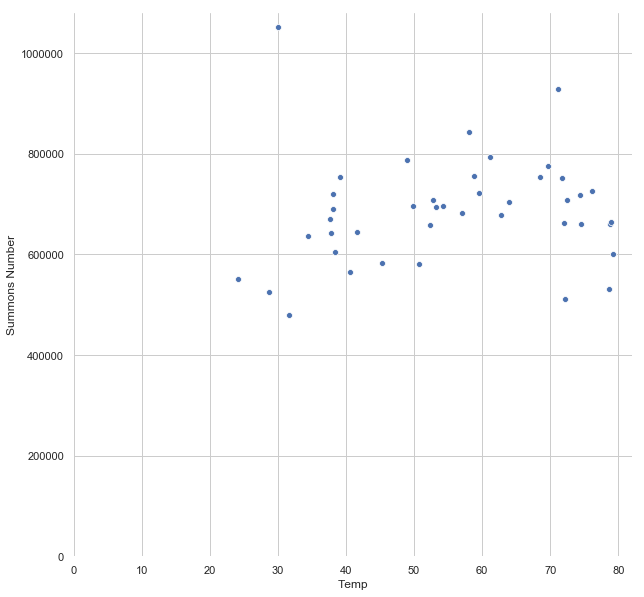

In [272]:
# Lisint 7.3 Colleting and plotting the data
seaborn.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10,10))
seaborn.despine(f, left=True, bottom=True)
with ProgressBar():
    seaborn.scatterplot(x='Temp', y='Summons Number', data=citations_and_temps.compute(), ax=ax)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)

[########################################] | 100% Completed |  5min 33.4s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


(0, 1080768.7017535216)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


(0, 81.99106301898041)

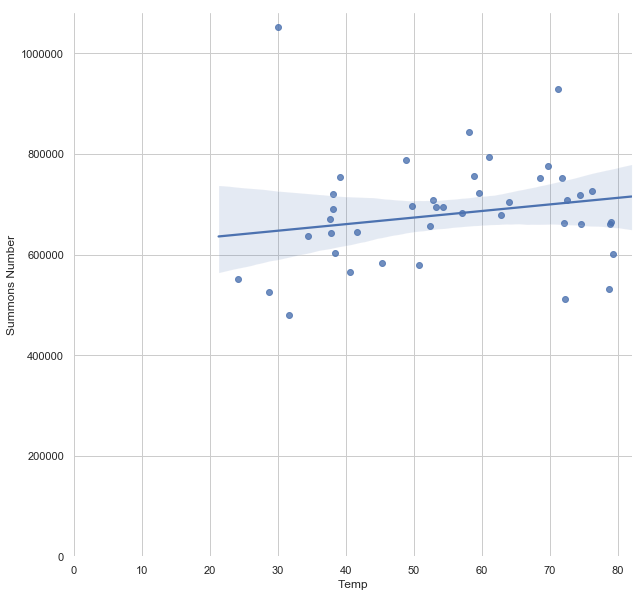

In [273]:
# Listing 7.4 Adding a regression line to a scatterplot using regplot
seaborn.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10,10))
seaborn.despine(f, left=True, bottom=True)
with ProgressBar():
    seaborn.regplot(x='Temp', y='Summons Number', data=citations_and_temps.compute(), ax=ax, robust=True)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)

[########################################] | 100% Completed |  5min 41.5s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


(0, 1086635.1455312395)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


(0, 81.99106301898041)

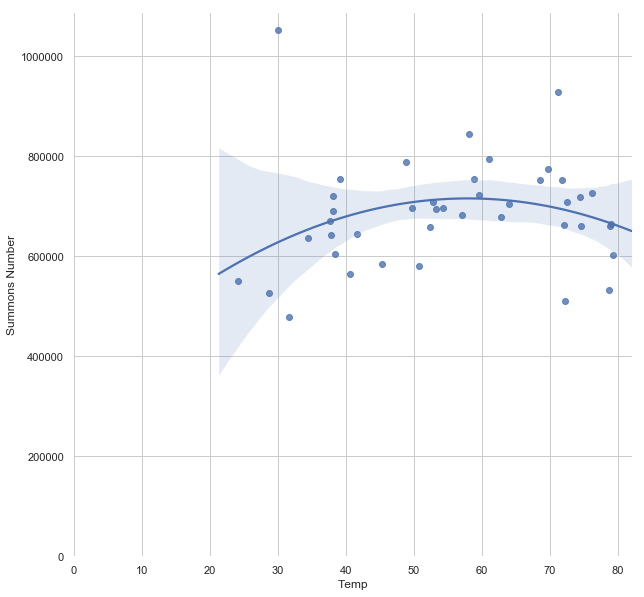

In [275]:
# Listing 7.5 Fitting a nonlinear curve to a dataset
seaborn.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10,10))
seaborn.despine(f, left=True, bottom=True)
with ProgressBar():
    seaborn.regplot(x='Temp', y='Summons Number', data=citations_and_temps.compute(), ax=ax, order=2)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)

## 7.3 Visualizing categorical relationships with violinplot 

In [276]:
# Listing 7.6 Reading in and filtering the data
row_filter = nyc_data_with_vehicle_age['Vehicle Color'].isin(['BLACK', 'WHITE', 'GREY', 'RED', 'GREEN', 'BLUE'])
col_filter = ['Vehicle Age', 'Vehicle Color']
ages_and_colors = nyc_data_with_vehicle_age[row_filter][col_filter]

In [277]:
# Lisint 7.7 Counting the observations
with ProgressBar():
    print(ages_and_colors.count().compute())

[########################################] | 100% Completed |  1min  5.4s
Vehicle Age      4971199
Vehicle Color    4971199
dtype: int64


[########################################] | 100% Completed |  1min  2.9s


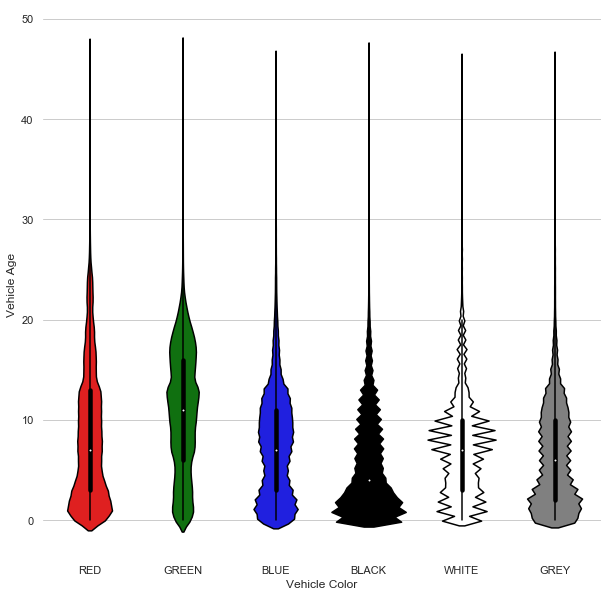

In [280]:
# Lisint 7.8 Creating the violinplot
seaborn.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 10))
seaborn.despine(f, left=True, bottom=True)
group_order = ['RED', 'GREEN', 'BLUE', 'BLACK', 'WHITE', 'GREY']
with ProgressBar():
    seaborn.violinplot(x='Vehicle Color', y='Vehicle Age', data=ages_and_colors.compute(), order=group_order,
                       palette=group_order, ax=ax)

[########################################] | 100% Completed |  1min  1.2s


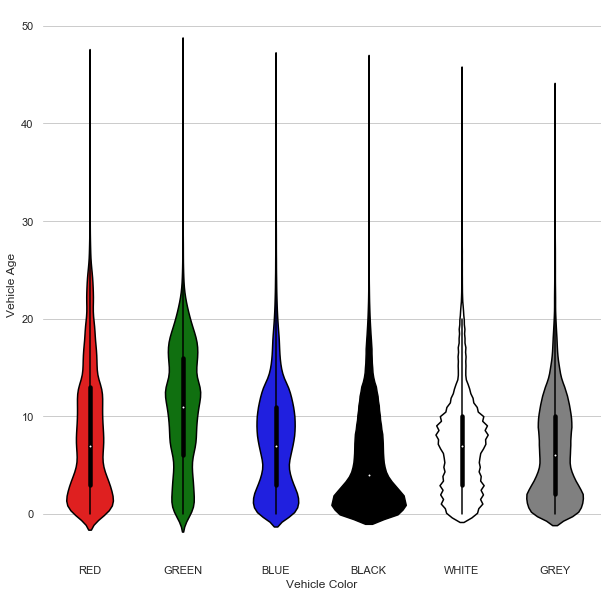

In [281]:
# Lisint 7.9 Sampling the filtered DF
sample = ages_and_colors.sample(frac=0.1)

seaborn.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 10))
seaborn.despine(f, left=True, bottom=True)
group_order = ['RED', 'GREEN', 'BLUE', 'BLACK', 'WHITE', 'GREY']
with ProgressBar():
    seaborn.violinplot(x='Vehicle Color', y='Vehicle Age', data=sample.compute(), order=group_order,
                       palette=group_order, ax=ax)

## 7.4 Visualizing two categorical relationships with heatmap

In [7]:
# Listing 7.10 Extracting month of year and the day of week
nyc_data_filtered = nyc_data_with_vehicle_age[nyc_data_with_vehicle_age['Issue Date'] < datetime(2017,1,1,)]
day_of_week = nyc_data_filtered['Issue Date'].apply(lambda x: x.strftime('%A'), meta=str)
month_of_year = nyc_data_filtered['Issue Date'].apply(lambda x: x.strftime('%B'), meta=str)

# Lising 7.11 Adding the columns back to DF
nyc_data_with_dates_raw = nyc_data_filtered.assign(DayOfWeek=day_of_week).assign(MonthOfYear=month_of_year)
column_map = {'DayOfWeek': 'Day of Week', 'MonthOfYear': 'Month of Year'}
nyc_data_with_dates = nyc_data_with_dates_raw.rename(columns=column_map)

In [8]:
# Lising 7.12 Counting the citations of month of year and day of week
with ProgressBar():
    summons_by_mydw = nyc_data_with_dates.groupby(['Day of Week', 'Month of Year']).count().compute()

[########################################] | 100% Completed |  8min 31.0s


In [9]:
# Listing 7.13 Transforming the result into a pivot table
heat_map_data = summons_by_mydw.reset_index().pivot('Month of Year', 'Day of Week', 'Summons Number')

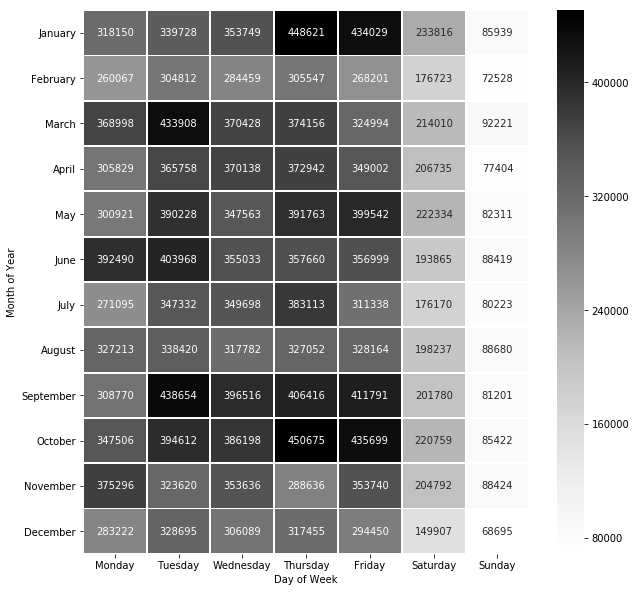

In [30]:
# Lisint 7.14 Creating the heatmap
months = ['January','February','March','April','May','June','July', 'August','September','October','November','December']
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
f, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(heat_map_data.loc[months,weekdays], annot=True, fmt="d", linewidths=1, ax=ax, cmap='Greys')

In [12]:
uniform_data = np.random.rand(10, 12)

In [16]:
uniform_data.shape

(10, 12)